In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import warnings
warnings.filterwarnings("ignore")

In [5]:
df=pd.read_csv("mental_health_survey_2018_to_2023.csv")

In [7]:
# For Automatically saving the charts.
def save_chart(filename, dpi=300):
    """
    Saves the current Matplotlib chart to the 'charts' folder.
    """
    plt.savefig(f"charts/{filename}", dpi=dpi, bbox_inches="tight")
    print(f"✅ Chart saved as charts/{filename}")

#

# Building ML Models

### 📌 Inputs Used for Model Training

To train the machine learning models, we used a comprehensive set of features derived from the survey dataset. These features capture demographics, workplace characteristics, employer policies, and personal history, all of which can influence an employee’s comfort in discussing mental health at work.

1. Demographic Factors
- Age
- Gender
- Race

2. Workplace Characteristics
- Company size (number of employees)
- Whether the employer is a tech organization
- Employee’s role type (Tech / Non-Tech)

3. Employer Policies and Practices
- Availability of mental health benefits as part of healthcare coverage
- Whether the employer has formally discussed mental health (e.g., wellness campaigns)
- Availability of resources to learn about mental health disorders
- Whether anonymity is protected in mental health/substance abuse treatment
- Importance placed on mental health vs. physical health by the employer

4. Employee Experiences and History
- Family history of mental illness
- Whether the respondent has experienced a mental health disorder
- Prior treatment history with mental health professionals
- Observations of coworkers discussing mental health and its influence on their own willingness

📌 Target Variables

The models are trained to predict employee comfort levels in discussing mental health at work:

1. Comfort with supervisors – “Would you feel comfortable discussing a mental health issue with your direct supervisor(s)?”
2. Comfort with coworkers – “Would you feel comfortable discussing a mental health issue with your coworkers?”

📌 Rationale

By including a wide range of demographic, workplace, and policy-related factors, the models aim to:

Identify key drivers that make employees more or less comfortable.

Understand the role of employer policies in fostering openness.

Provide insights into how demographics (age, gender, role type) shape perceptions of mental health at work.

This ensures that the predictions are not only accurate but also actionable — enabling organizations to focus on the most impactful areas for improving workplace mental health support.

#

# Predicting Comfort Discussing Mental Health (with Coworker)

## *1. Confusion Matrix - Logistic Regression*

Classification Report:
              precision    recall  f1-score   support

       Maybe       0.55      0.62      0.59        90
          No       0.57      0.50      0.53        60
     Unknown       1.00      1.00      1.00        38
         Yes       0.62      0.58      0.60        62

    accuracy                           0.64       250
   macro avg       0.69      0.68      0.68       250
weighted avg       0.64      0.64      0.64       250

✅ Chart saved as charts/Confusion_Matrix_Logistic_Regression_Coworker_Comfort.png


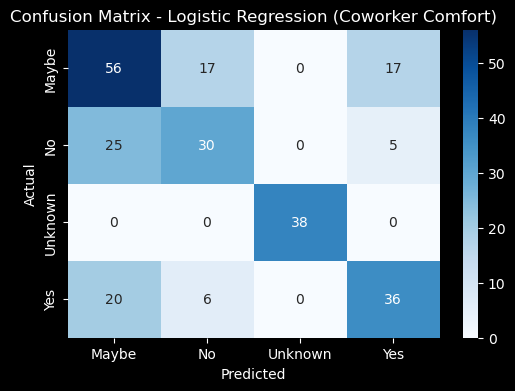

In [18]:
target_col = "Would you feel comfortable discussing a mental health issue with your coworkers?"

features = df.drop(columns=[target_col, "Would you feel comfortable discussing a mental health issue with your direct supervisor(s)?", "year"])

X = features
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

categorical_cols = X.select_dtypes(include=['object', 'bool']).columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numeric_cols)
    ])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(multi_class="multinomial", max_iter=1000))
])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression (Coworker Comfort)")
save_chart("Confusion_Matrix_Logistic_Regression_Coworker_Comfort.png")
plt.show()

### Overall Accuracy:
- The model achieved an accuracy of 64%, which is slightly higher than Logistic Regression on supervisor comfort.
- This suggests that coworker comfort might be slightly easier to predict with the available features.

### Class-wise Insights:
1. Maybe: Precision = 0.55, Recall = 0.62 → The model correctly captures a majority of employees who said “Maybe,” though with moderate misclassifications.
2. No: Precision = 0.57, Recall = 0.50 → Half of the “No” responses were misclassified, showing this category is harder to distinguish.
3. Unknown: Precision = 1.00, Recall = 1.00 → Perfect classification. The model reliably predicts respondents who are unsure.
4. Yes: Precision = 0.62, Recall = 0.58 → The model identifies “Yes” fairly well, though some overlap with “Maybe.”

### Confusion Matrix Findings:
- Many “Maybe” responses were misclassified as “No” or “Yes”, indicating overlap in the features influencing these classes.
- The “Unknown” class is perfectly predicted, likely due to strong feature signals or smaller variability in this group.
- A noticeable number of “Yes” responses were confused with “Maybe”, suggesting that people leaning toward openness may have overlapping characteristics with those still uncertain.

### Balanced Performance:
- The macro average F1-score (0.68) suggests relatively balanced treatment across classes.
- The weighted F1-score (0.64) aligns closely with accuracy, showing consistent model performance across the dataset.

#

## *2. Confusion Matrix - Random Forest*

In [22]:
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numeric_cols)
    ]
)

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        class_weight="balanced",
        random_state=42
    ))
])

# Train
rf_pipeline.fit(X_train, y_train)

# Predict
y_pred_rf = rf_pipeline.predict(X_test)


Classification Report - Random Forest (Supervisor Comfort):

              precision    recall  f1-score   support

       Maybe       0.52      0.72      0.61        90
          No       0.66      0.45      0.53        60
     Unknown       1.00      1.00      1.00        38
         Yes       0.66      0.50      0.57        62

    accuracy                           0.64       250
   macro avg       0.71      0.67      0.68       250
weighted avg       0.66      0.64      0.64       250

✅ Chart saved as charts/Confusion_Matrix_Random_Forest_Coworker_Comfort.png


<Figure size 600x400 with 0 Axes>

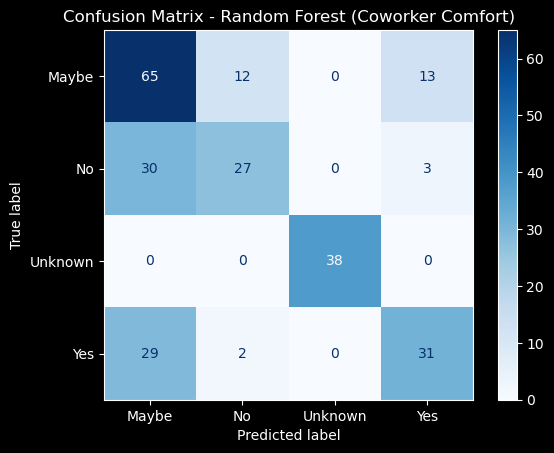

In [28]:
print("Classification Report - Random Forest (Supervisor Comfort):\n")
print(classification_report(y_test, y_pred_rf))

cm = confusion_matrix(y_test, y_pred_rf, labels=rf_pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_pipeline.classes_)
plt.figure(figsize=(6,4))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Random Forest (Coworker Comfort)")
save_chart("Confusion_Matrix_Random_Forest_Coworker_Comfort.png")
plt.show()


### Overall Accuracy:
- The model achieved 64% accuracy, same as Logistic Regression.
- However, performance distribution across classes is slightly different, with Random Forest improving some areas while struggling in others.

### Class-wise Insights:
1. Maybe: Precision = 0.52, Recall = 0.72 → Random Forest captures most of the “Maybe” cases but with many false positives (moderate precision).
2. No: Precision = 0.66, Recall = 0.45 → Performs slightly better in precision compared to Logistic Regression, but recall remains weak (many “No” cases misclassified as “Maybe”).
3. Unknown: Precision = 1.00, Recall = 1.00 → Same as Logistic Regression, this class is perfectly predicted, showing strong separability.
4. Yes: Precision = 0.66, Recall = 0.50 → Slightly improved precision compared to Logistic Regression, but recall is weaker (fewer “Yes” correctly predicted).

### Confusion Matrix Findings:
- A significant portion of “Yes” cases (29) were predicted as “Maybe”, suggesting Random Forest confuses between openness and uncertainty.
- “No” cases are often misclassified as “Maybe”, consistent with the difficulty of distinguishing these two.
- As before, “Unknown” remains perfectly classified, strengthening its reliability.

### Balanced Performance:
- Macro average F1-score = 0.68, almost identical to Logistic Regression.
- Weighted F1-score = 0.64, again consistent with overall accuracy.

#

## *3. Classification Report - XGBoost*

Classification Report - XGBoost (Coworker Comfort):

              precision    recall  f1-score   support

       Maybe       0.55      0.60      0.57        90
          No       0.56      0.52      0.54        60
     Unknown       1.00      1.00      1.00        38
         Yes       0.59      0.55      0.57        62

    accuracy                           0.63       250
   macro avg       0.67      0.67      0.67       250
weighted avg       0.63      0.63      0.63       250

✅ Chart saved as charts/Confusion_Matrix_XGBoost_Coworker_Comfort.png


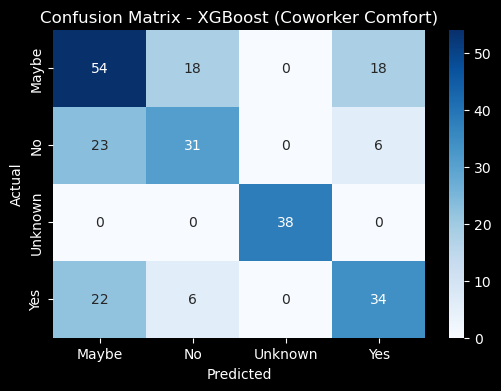

In [39]:
target_col = "Would you feel comfortable discussing a mental health issue with your coworkers?"

X = df.drop(columns=[target_col, "Would you feel comfortable discussing a mental health issue with your direct supervisor(s)?", "year"])
y = df[target_col]

le = LabelEncoder()
y_encoded = le.fit_transform(y)             
class_labels = list(le.classes_)            

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numeric_cols)
    ]
)

xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        objective="multi:softprob",
        eval_metric="mlogloss",
        learning_rate=0.1,
        max_depth=6,
        n_estimators=200,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        use_label_encoder=False
    ))
])

xgb_pipeline.fit(X_train, y_train)

y_pred_xgb = xgb_pipeline.predict(X_test)

print("Classification Report - XGBoost (Coworker Comfort):\n")
print(classification_report(
    y_test,
    y_pred_xgb,
    target_names=class_labels  
))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost (Coworker Comfort)")
save_chart("Confusion_Matrix_XGBoost_Coworker_Comfort.png")
plt.show()


### Overall Accuracy:
XGBoost achieved 63% accuracy, slightly lower than Logistic Regression and Random Forest (both at 64%).

### Class-wise Insights:
1. Maybe: Precision = 0.55, Recall = 0.60 → Moderate balance; captures “Maybe” cases reasonably well but still with notable misclassifications.
2. No: Precision = 0.56, Recall = 0.52 → Similar to Logistic Regression, slightly better balance compared to Random Forest.
3. Unknown: Precision = 1.00, Recall = 1.00 → Perfect classification, consistent across all models so far.
4. Yes: Precision = 0.59, Recall = 0.55 → Performance close to “Maybe,” but with frequent confusion (misclassified as “Maybe”).

### Confusion Matrix Findings:
- Yes vs Maybe confusion: 22 “Yes” responses were predicted as “Maybe.”
- No vs Maybe overlap: 23 “No” responses predicted as “Maybe,” similar to earlier models.
- Unknown remains perfectly classified, showing strong separation.

### Balanced Performance:
- Macro avg F1-score = 0.67, slightly below Random Forest and Logistic Regression.
- Weighted avg F1-score = 0.63, aligned with the overall accuracy.

### Key Takeaway:
XGBoost delivers stable but not superior performance compared to Logistic Regression and Random Forest. It shows consistent patterns of confusion between “Maybe,” “No,” and “Yes,” but retains perfect classification for “Unknown.”

#

## *4. Confusion Matrix - CatBoost*

0:	learn: 0.6270000	test: 0.6000000	best: 0.6000000 (0)	total: 231ms	remaining: 1m 55s
100:	learn: 0.8300000	test: 0.6640000	best: 0.6800000 (63)	total: 29.3s	remaining: 1m 55s
200:	learn: 0.9340000	test: 0.6440000	best: 0.6800000 (63)	total: 58.2s	remaining: 1m 26s
300:	learn: 0.9870000	test: 0.6280000	best: 0.6800000 (63)	total: 1m 27s	remaining: 57.7s
400:	learn: 0.9990000	test: 0.6520000	best: 0.6800000 (63)	total: 1m 58s	remaining: 29.2s
499:	learn: 1.0000000	test: 0.6480000	best: 0.6800000 (63)	total: 2m 27s	remaining: 0us

bestTest = 0.68
bestIteration = 63

Shrink model to first 64 iterations.
Classification Report - CatBoost (Coworker Comfort):

              precision    recall  f1-score   support

       Maybe       0.59      0.70      0.64        90
          No       0.63      0.67      0.65        60
     Unknown       1.00      1.00      1.00        38
         Yes       0.69      0.47      0.56        62

    accuracy                           0.68       250
   macro av

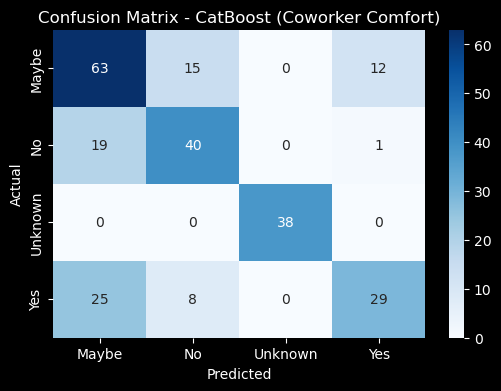

In [44]:
target_col = "Would you feel comfortable discussing a mental health issue with your coworkers?"

X = df.drop(columns=[target_col, "Would you feel comfortable discussing a mental health issue with your direct supervisor(s)?", "year"])
y = df[target_col]

le = LabelEncoder()
y_encoded = le.fit_transform(y)             
class_labels = list(le.classes_)            

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

for col in categorical_cols:
    X_train[col] = X_train[col].astype(str).fillna("Unknown")
    X_test[col] = X_test[col].astype(str).fillna("Unknown")

cat_features_idx = [X_train.columns.get_loc(col) for col in categorical_cols]

cat_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    eval_metric='Accuracy',
    random_seed=42,
    verbose=100
)

cat_model.fit(X_train, y_train, cat_features=cat_features_idx, eval_set=(X_test, y_test))

y_pred_cat = cat_model.predict(X_test)

print("Classification Report - CatBoost (Coworker Comfort):\n")
print(classification_report(
    y_test,
    y_pred_cat,
    target_names=class_labels
))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_cat)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - CatBoost (Coworker Comfort)")
save_chart("Confusion_Matrix_CatBoost_Coworker_Comfort.png")
plt.show()


### Overall Accuracy:
CatBoost achieved 68% accuracy, which is the highest among all models tested (Logistic Regression, Random Forest, and XGBoost each had 63–64%).

### Class-wise Insights:
1. Maybe: Precision = 0.59, Recall = 0.70 → CatBoost is better at identifying “Maybe” responses than previous models.
2. No: Precision = 0.63, Recall = 0.67 → Strongest balance so far, reducing misclassifications between “No” and “Maybe.”
3. Unknown: Precision = 1.00, Recall = 1.00 → Perfect classification, same as other models.
4. Yes: Precision = 0.69, Recall = 0.47 → Precision improved compared to others, but recall dropped, meaning CatBoost predicts fewer “Yes” cases correctly.

### Confusion Matrix Findings:
- “Yes” responses are sometimes confused with “Maybe” (25 misclassified).
- “No” is well captured, with 40 correctly predicted (best across all models).
- “Unknown” continues to be separated perfectly.

### Macro & Weighted Averages:
- Macro avg F1-score = 0.71, the best among all models.
- Weighted avg F1-score = 0.68, confirming CatBoost’s superior balance across categories.

### Key Takeaway:
CatBoost provided the best performance for predicting coworker comfort, with the highest overall accuracy (68%) and the strongest balance in predicting “Maybe” and “No.” The tradeoff is slightly lower recall for “Yes,” but overall, it is the most reliable model tested so far.

#

# Model Comparison – Coworker Comfort Prediction

| Model                   | Accuracy | Precision (Macro) | Recall (Macro) | F1-Score (Macro) | Strengths                                                                          | Weaknesses                                                                 |
| ----------------------- | -------- | ----------------- | -------------- | ---------------- | ---------------------------------------------------------------------------------- | -------------------------------------------------------------------------- |
| **Logistic Regression** | 0.64     | 0.69              | 0.68           | 0.68             | Simple, interpretable; perfect classification of *Unknown*.                        | Struggles with *Maybe* vs *Yes* overlap; moderate “No” detection.          |
| **Random Forest**       | 0.64     | 0.71              | 0.67           | 0.68             | High recall for *Maybe*; perfect *Unknown* detection.                              | Weak recall for *Yes*; many *Yes → Maybe* misclassifications.              |
| **XGBoost**             | 0.63     | 0.67              | 0.67           | 0.67             | Balanced performance across classes; strong *Unknown* detection.                   | Lower accuracy than Random Forest & CatBoost; struggles with *Yes* recall. |
| **CatBoost**            | **0.68** | **0.73**          | **0.71**       | **0.71**         | Best overall accuracy; strong performance for *Maybe* and *No*; perfect *Unknown*. | Recall for *Yes* is weaker (many *Yes → Maybe*).                           |
